# Data visualization for the different parks separately

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, acf, pacf, plot_pacf

import sys
import os

from satprod.data_handlers.num_data import NumericalDataHandler

In [2]:
pd.set_option("display.max_rows", 700, "display.max_columns", 50)

In [11]:
num = NumericalDataHandler()

data = num.read_formatted_data(nan=True)

split = datetime(2020, 5, 1, 0)
data = data[data.index < split]

In [12]:
dev_mode = False # to not have to scroll over all the plots when coding

## Functions

In [21]:
def wind_speed_plots(park: str):
    #acf_wind = acf(enc_df[f'wind_speed_{park}'].dropna(axis=0).values, nlags=24*14, fft=False)
    
    fig = plot_acf(data[f'wind_speed_{park}'].dropna(axis=0).values, lags=24*400)
    plt.xlabel('hours')
    plt.show()
    
    fig = plot_acf(data[f'wind_speed_{park}'].dropna(axis=0).values, lags=24*30)
    plt.xlabel('hours')
    plt.show()
    
    fig = plot_acf(data[f'wind_speed_{park}'].dropna(axis=0).values, lags=24*4)
    plt.xlabel('hours')
    plt.show()
    
    fig = plot_pacf(data[f'wind_speed_{park}'].dropna(axis=0), lags=24*7)
    plt.xlabel('hours')
    plt.show()
    
def wind_speed_forecast_change(park: str):
    ch_wind = (data[f'wind_speed_{park}+1h'].shift()-data[f'wind_speed_{park}'])
    
    # remove all rows where there was no update in the forecasts, and use absolute values
    ch_wind = ch_wind[np.abs(ch_wind) > 1e-6]
    
    plt.figure(figsize=(16,4))
    ch_wind.plot()
    plt.title('Wind speed forecast change when updated')
    plt.show()
    
    print(f'Mean forecast change when updated: {np.mean(ch_wind)}.')
    
    plt.figure(figsize=(16,4))
    np.abs(ch_wind).plot()
    plt.title('Wind speed forecast absolute change when updated')
    plt.show()
    
    print(f'Mean forecast absolute change when updated: {np.mean(np.abs(ch_wind))}.')

def wind_direction_plots(park: str):
    plot_acf(data[f'wind_direction_{park}_sin'].dropna(axis=0).values, lags=24*10)
    plt.title('Autocorrelation, wind direction sine')
    plt.xlabel('hours')
    plt.show()
    plot_acf(data[f'wind_direction_{park}_cos'].dropna(axis=0).values, lags=24*10)
    plt.title('Autocorrelation, wind direction cosine')
    plt.xlabel('hours')
    plt.show()

    plot_pacf(data[f'wind_direction_{park}_sin'].dropna(axis=0).values, lags=24*10)
    plt.title('Partial autocorrelation, wind direction sine')
    plt.xlabel('hours')
    plt.show()
    plot_pacf(data[f'wind_direction_{park}_cos'].dropna(axis=0).values, lags=24*10)
    plt.title('Partial autocorrelation, wind direction cosine')
    plt.xlabel('hours')
    plt.show()
    
def production_plots(park: str):
    fig = plot_acf(data[f'production_{park}'].dropna(axis=0).values, lags=24*400)
    plt.xlabel('hours')
    plt.show()
    
    fig = plot_acf(data[f'production_{park}'].dropna(axis=0).values, lags=24*30)
    plt.xlabel('hours')
    plt.show()

    fig = plot_acf(data[f'production_{park}'].dropna(axis=0).values, lags=24*4)
    plt.xlabel('hours')
    plt.show()

    fig = plot_pacf(data[f'production_{park}'].dropna(axis=0), lags=24*7)
    plt.xlabel('hours')
    plt.show()
    
def prod_wind_speed_correlation(park):
    if park=='skom':
        park_name = 'bess'
    else:
        park_name = park
    prod_shift_df = pd.DataFrame()
    names = []
    for i in range(0, 5):
        new = data[f'production_{park}'].shift(i)
        names.append(f'production_{park}_shift_{i}')
        prod_shift_df = pd.concat([prod_shift_df, new], axis=1)
    prod_shift_df.columns = names

    wind_shift_df = pd.DataFrame()
    names = []
    for i in range(0, 5):
        new = data[f'wind_speed_{park_name}'].shift(i)
        names.append(f'wind_speed_{park_name}_shift_{i}')
        wind_shift_df = pd.concat([wind_shift_df, new], axis=1)
    wind_shift_df.columns = names

    combo = pd.concat([wind_shift_df, prod_shift_df], axis=1)
    del wind_shift_df, prod_shift_df

    fig, ax = plt.subplots(figsize=(12,10))
    sns.heatmap(combo.corr(), ax=ax)
    plt.show()

## Bessaker

### Wind speed

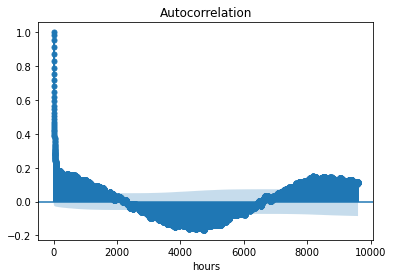

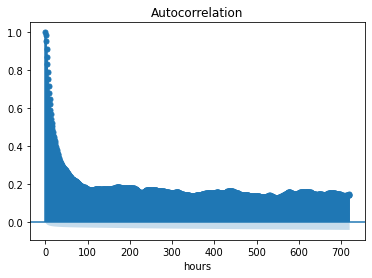

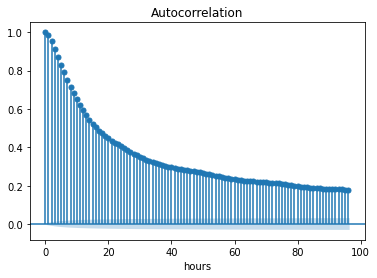

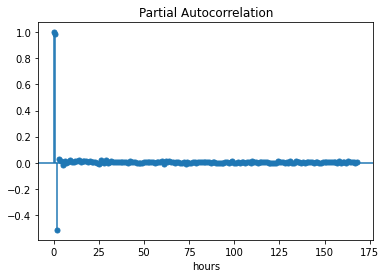

In [22]:
if not dev_mode: wind_speed_plots('bess')

### Wind direction

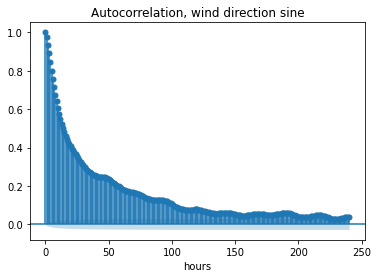

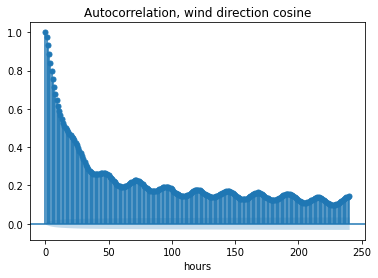

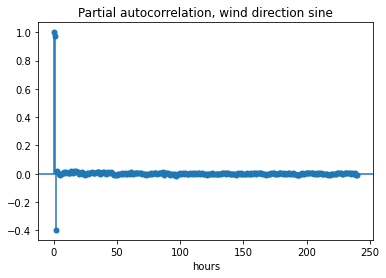

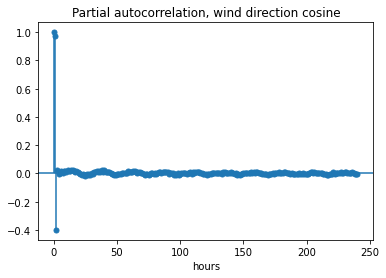

In [23]:
if not dev_mode: wind_direction_plots('bess')

### Production

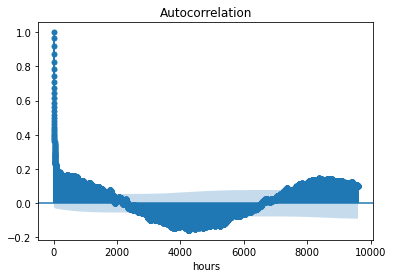

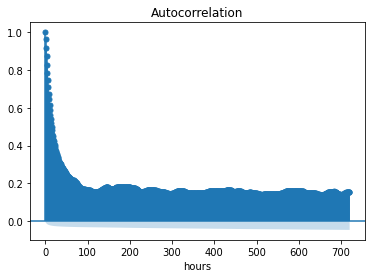

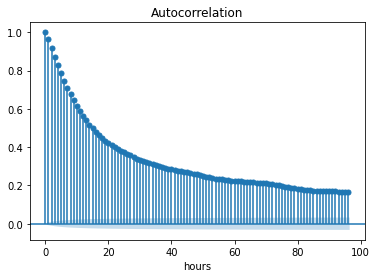

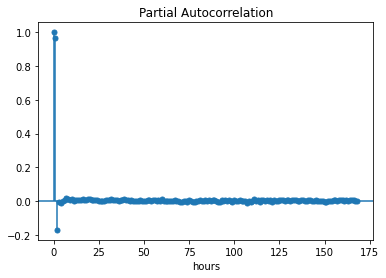

In [24]:
if not dev_mode: production_plots('bess')

### Relation between wind speed and production

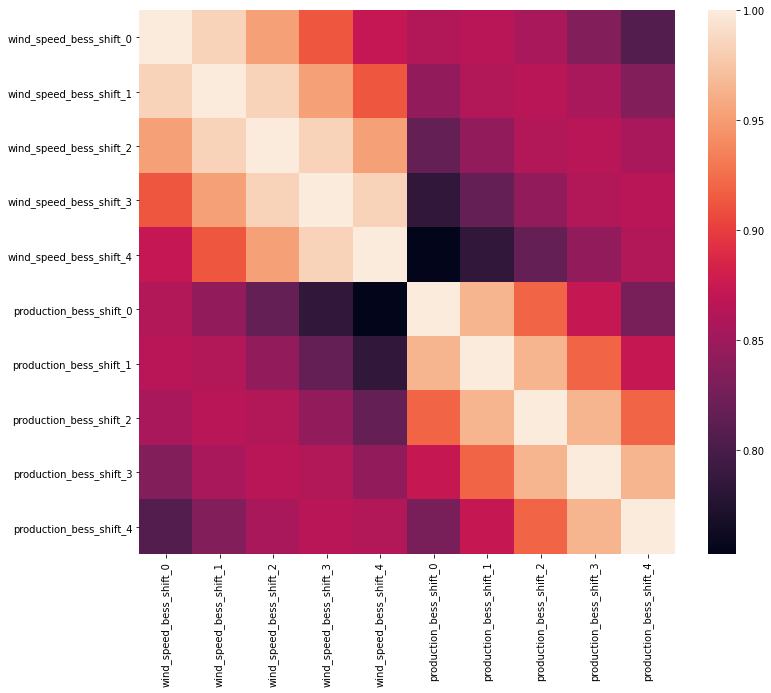

In [17]:
if not dev_mode: prod_wind_speed_correlation('bess')

Production is most correlated with the wind speed in the previous hour. That is a helpful relation for the forecasting model.

## Skomaker

Numerical forecasts at Skomakerfjellet are identical to the ones at Bessakerfjellet, and the plots are therefore not repeated. Production is, however, not identical, and is therefore shown.

### Production

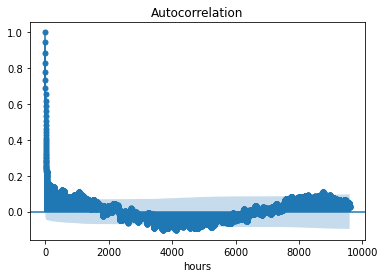

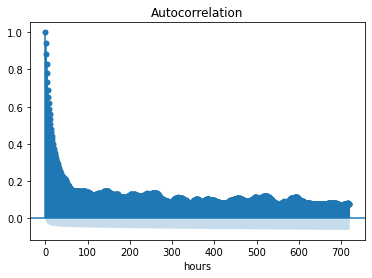

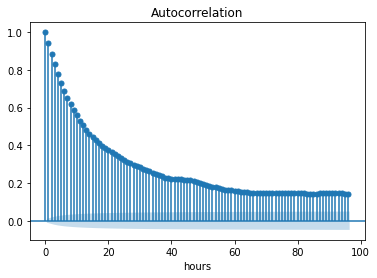

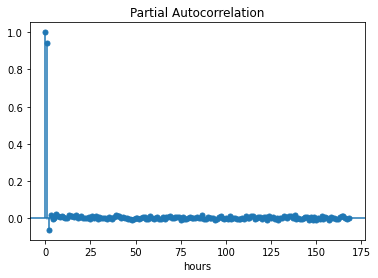

In [25]:
if not dev_mode: production_plots('skom')

### Relation between wind speed, wind direction, and production

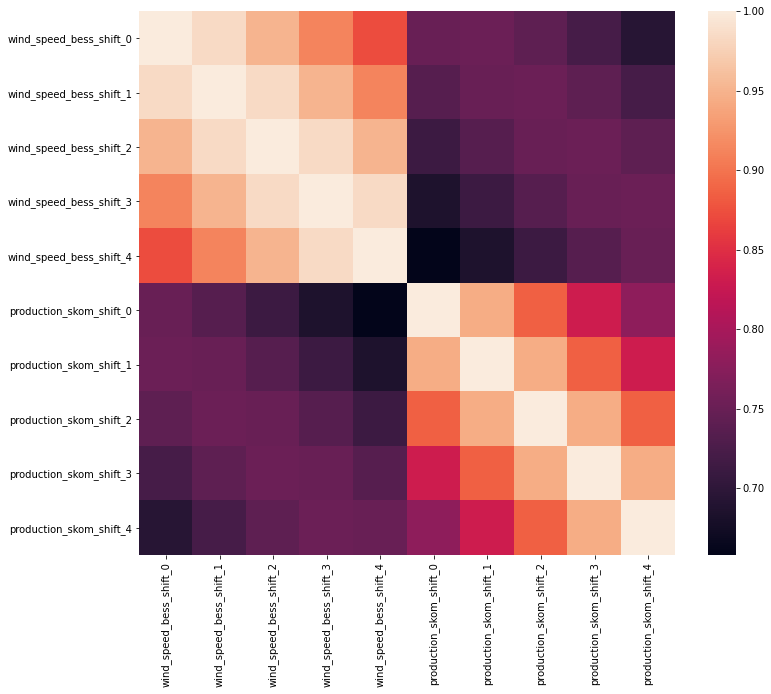

In [26]:
if not dev_mode: prod_wind_speed_correlation('skom')

## Valsneset

### Wind speed

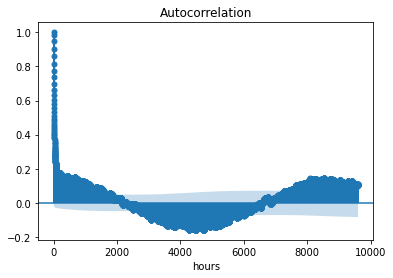

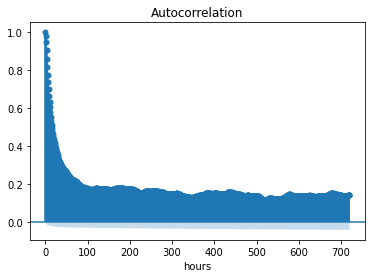

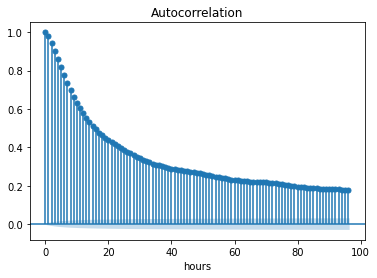

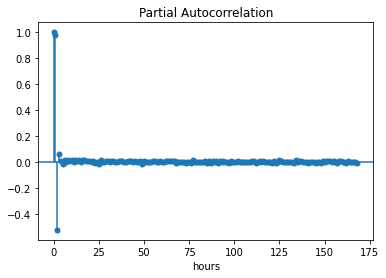

In [27]:
if not dev_mode: wind_speed_plots('vals')

### Wind direction

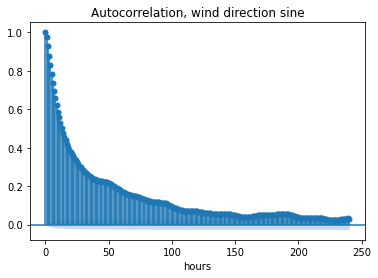

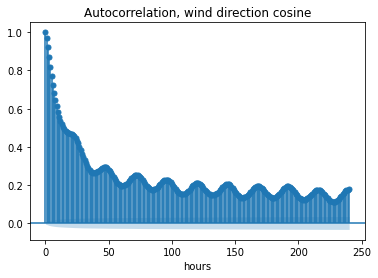

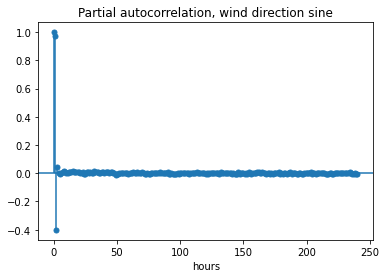

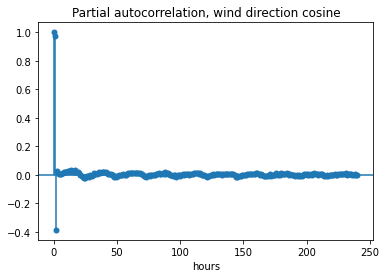

In [28]:
if not dev_mode: wind_direction_plots('vals')

### Production

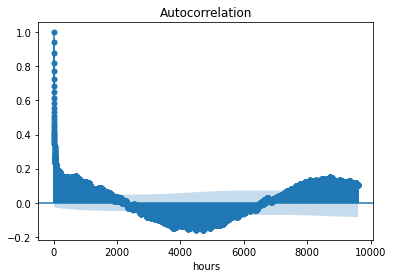

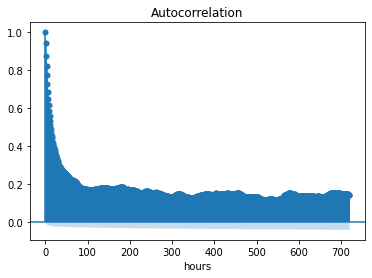

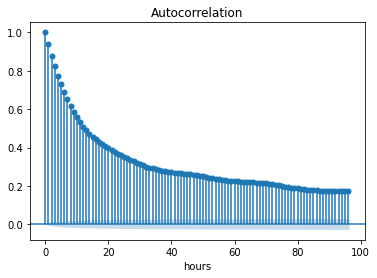

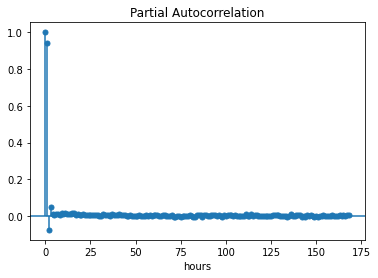

In [29]:
if not dev_mode: production_plots('vals')

### Relation between wind speed, wind direction, and production

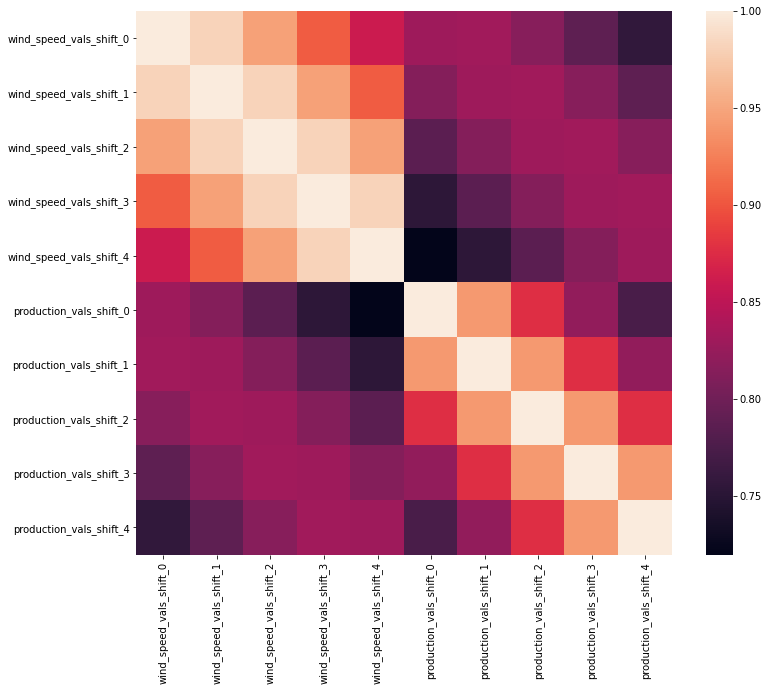

In [30]:
if not dev_mode: prod_wind_speed_correlation('vals')

## Ytre vikna

### Wind speed

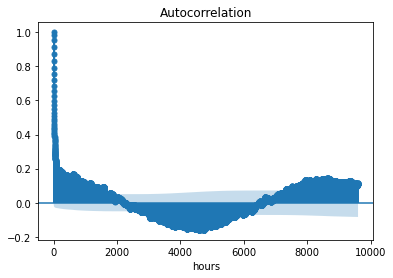

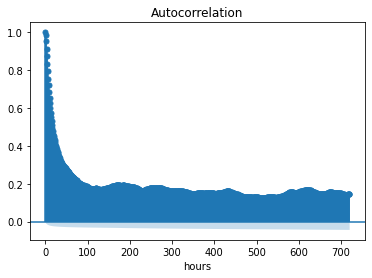

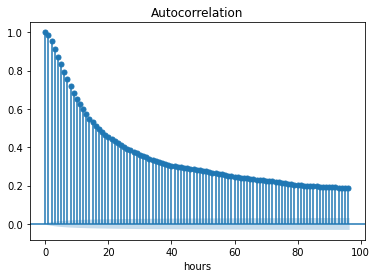

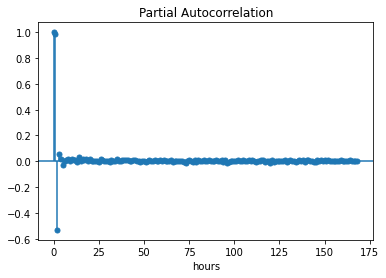

In [31]:
if not dev_mode: wind_speed_plots('yvik')

### Wind direction

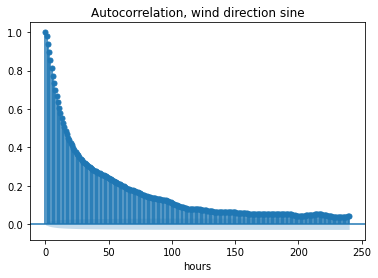

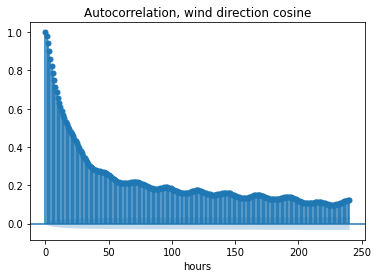

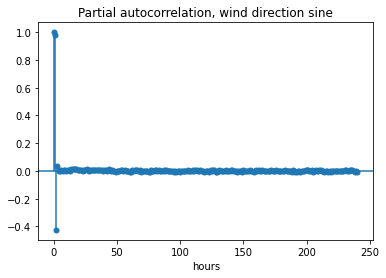

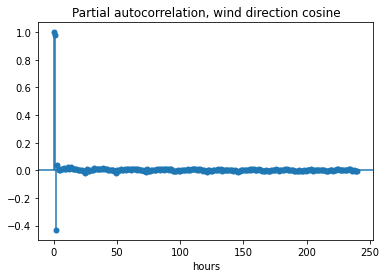

In [32]:
if not dev_mode: wind_direction_plots('yvik')

### Production

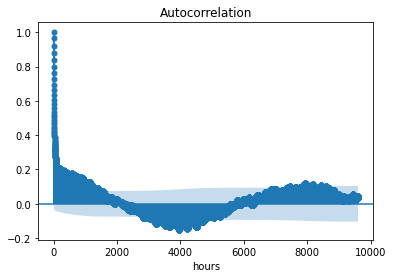

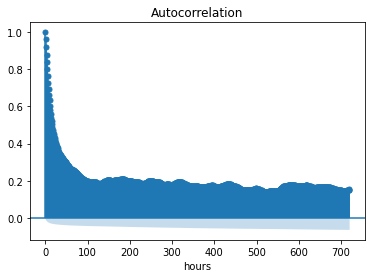

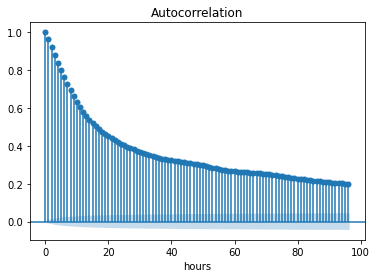

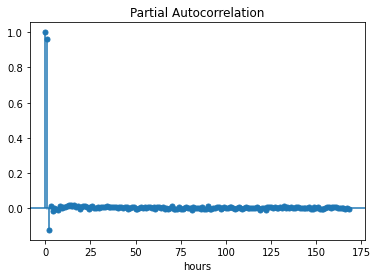

In [33]:
if not dev_mode: production_plots('yvik')

### Relation between wind speed, wind direction, and production

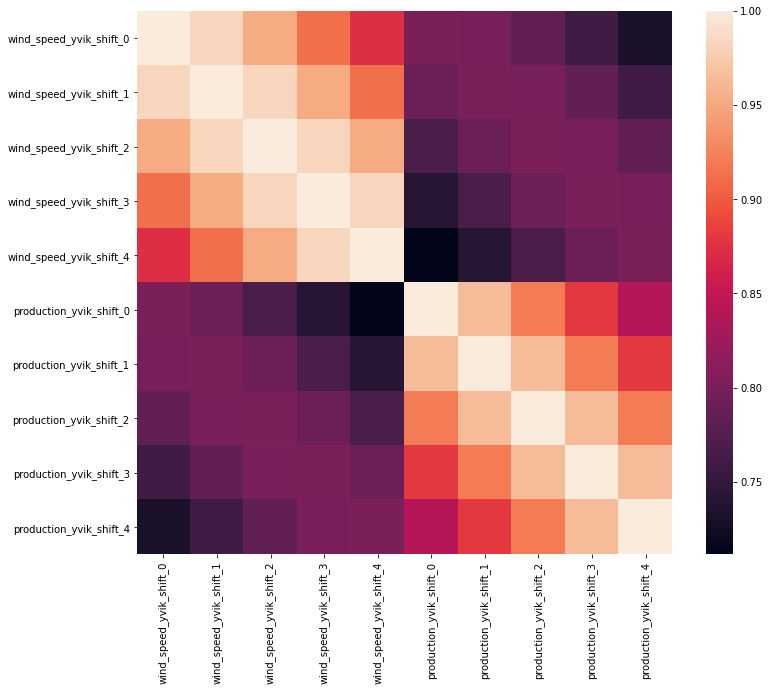

In [34]:
if not dev_mode: prod_wind_speed_correlation('yvik')